## Trabajo Fin de Grado
### Gestor de Quirófanos
### Implementación de Algoritmo Genético para asignación de quirófanos

#### Autor: Jesús García Armario

In [1]:
# Imports necesarios
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms
import sys
sys.path.append('../')
from Heuristicas.Utils import Quirofano, ActoQuirurgico, Heuristicas
import random
import math
import matplotlib.pyplot as plt
from utilsGenetico import cromosomaAleatorio, evaluar, distance, validar, cruce, mutacion

In [2]:
# Importamos el listado preprocesado de una especialidad para las pruebas
filename = '..\\..\\Datos\\Listados_Preprocesados\\ListadoInterv_Preprocesado_MAXILOFACIAL.xlsx'
df = pd.read_excel(filename)
# Seleccionamos una muestra aleatoria de 100 pacientes
df = df.sample(n=100, random_state=1)
# Nos quedamos sólo con el NHC, Ponderación y duración
df = df[['NHC', 'PONDERACIÓN', 'DURACIÓN']]
# Sumamos a la duración 25 minutos por paciente para tener en cuenta el tiempo de preparación
df['DURACIÓN'] = df['DURACIÓN'] + 25
ventana = 30
# Dividimos la duración entre la ventana y redondeamos hacia arriba
df['DURACIÓN'] = df['DURACIÓN'].apply(lambda x: math.ceil(x/ventana))
# Creamos un set de actos quirúrgicos
actos_pendientes = list()
i = 0
for elemento in df.itertuples():
    actos_pendientes.append(ActoQuirurgico(i, elemento[3], elemento[1], elemento[2]))
    i += 1

In [3]:
# Definimos al individuo
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("cromosoma", cromosomaAleatorio, tiempos=16, quirofanos=3, dias=5, actos_pendientes=actos_pendientes)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.cromosoma)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [4]:
toolbox.register("evaluate", evaluar, tiempos=16, quirofanos=3, dias=5, actos_pendientes=actos_pendientes)
toolbox.register("mate", cruce)
toolbox.register("mutate", mutacion)
toolbox.register("select", tools.selTournament, tournsize=3)

In [5]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean) 
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max) 

In [6]:
# Definimos el algoritmo genético
def algoritmo_genetico(poblacion, probabilidad_cruce, probabilidad_mutacion, numero_generaciones):
    # Evaluamos la población
    fitnesses = list(map(toolbox.evaluate, poblacion))
    for ind, fit in zip(poblacion, fitnesses):
        ind.fitness.values = fit
    # Inicializamos las estadísticas
    record = stats.compile(poblacion)
    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + (stats.fields if stats else [])
    # Guardamos las estadísticas
    logbook.record(gen=0, evals=len(poblacion), **record)
    print(logbook.stream)
    # Iniciamos contador de generaciones sin mejora
    contador = 0
    hof = tools.HallOfFame(1)
    hof.update(poblacion)
    # Ejecutamos el algoritmo genético
    for g in range(1, numero_generaciones):
        # Seleccionamos a la población
        poblacion = toolbox.select(poblacion, len(poblacion))
        # Clonamos a los individuos
        hijos = list(map(toolbox.clone, poblacion))
        # Aplicamos el cruce
        for hijo1, hijo2 in zip(hijos[::2], hijos[1::2]):
            if random.random() < probabilidad_cruce:
                toolbox.mate(hijo1, hijo2)
                del hijo1.fitness.values
                del hijo2.fitness.values
        # Aplicamos la mutación
        for hijo in hijos:
            if random.random() < probabilidad_mutacion:
                toolbox.mutate(hijo)
                del hijo.fitness.values
        # Evaluamos a los individuos con fitness inválido
        invalid_ind = [ind for ind in hijos if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        # Reemplazamos a la población
        poblacion[:] = hijos
        # Guardamos las estadísticas
        record = stats.compile(poblacion)
        logbook.record(gen=g, evals=len(poblacion), **record)
        print(logbook.stream)
        # Comprobamos si el mejor individuo ha mejorado
        if hof[0].fitness.values[0] > record['min']:
            contador = 0
        else:
            contador += 1
        hof.update(poblacion)
        # Si no ha mejorado en 50 generaciones, paramos
        if contador == 100:
            break
    return poblacion, logbook, hof

In [7]:
poblacion = toolbox.population(n=200)
# Cargamos el algoritmo genético
poblacion, logbook, hof = algoritmo_genetico(poblacion, probabilidad_cruce=0.85, probabilidad_mutacion=0.15, numero_generaciones=1000)

gen	evals	avg   	std    	min       	max
0  	200  	3.7651	1.63678	0.00278909	8  
1  	200  	2.44032	1.41945	0.00278909	9  
2  	200  	1.39583	1.08474	0.00278909	4  
3  	200  	0.581785	0.749354	0.00278909	3  
4  	200  	0.162657	0.428428	0.00278909	3  
5  	200  	0.157618	0.469217	0.00278909	3  
6  	200  	0.107626	0.391694	0.00278909	2  
7  	200  	0.127544	0.434442	0.00278774	3  
8  	200  	0.167497	0.526262	0.00278774	3  
9  	200  	0.162481	0.513426	0.00271082	4  
10 	200  	0.147507	0.472492	0.00271082	3  
11 	200  	0.0676408	0.300719	0.00271082	2  
12 	200  	0.11253  	0.383854	0.00271082	2  
13 	200  	0.172443 	0.538767	0.00271082	4  
14 	200  	0.157435 	0.490123	0.002707  	3  
15 	200  	0.11251  	0.421128	0.00270592	3  
16 	200  	0.107507 	0.416472	0.00270592	3  
17 	200  	0.0975068	0.354259	0.00270504	2  
18 	200  	0.0924928	0.318515	0.0027048 	2  
19 	200  	0.0975048	0.354259	0.0027048 	2  
20 	200  	0.067572 	0.316924	0.0027048 	3  
21 	200  	0.0925436	0.389156	0.0027048 	3  
22 	200  	

In [8]:
print("Mejor individuo: ", hof[0])
print("Fitness del mejor: ", hof[0].fitness.values[0])

Mejor individuo:  [82, 75, 19, 62, 0, 'A', 32, 24, 45, 33, 'V', 90, 'A', 78, 91, 'A', 'B', 23, 50, 11, 67, 27, 'V', 'A', 16, 15, 97, 40, 'A', 47, 66, 85, 48, 'A', 'B', 13, 83, 17, 79, 14, 60, 'A', 54, 99, 21, 'A', 72, 35, 26, 12, 53, 'A', 'B', 65, 69, 70, 28, 'V', 39, 'A', 59, 51, 57, 9, 89, 8, 1, 'A', 7, 4, 74, 42, 'A', 'B', 87, 80, 46, 63, 61, 'V', 92, 'A', 37, 29, 2, 44, 84, 52, 'A', 43, 68, 86, 56, 'A', 'B']
Fitness del mejor:  0.0026698868012951273


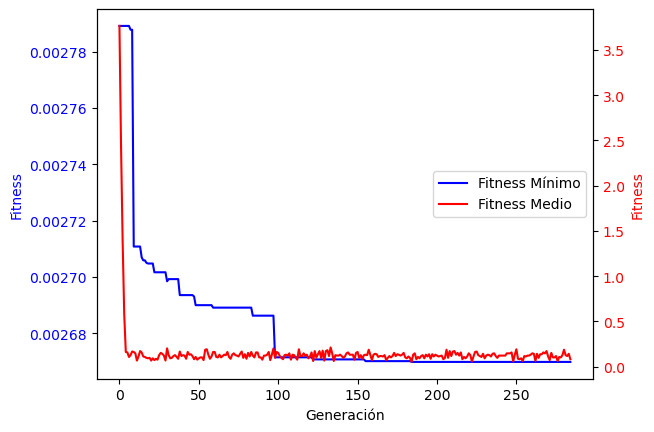

In [9]:
def representaAlgoritmoGenetico(logbook):
    # Representamos el logbook
    gen = logbook.select("gen")
    fit_mins = logbook.select("min")
    fit_maxs = logbook.select("max")
    fit_averages = logbook.select("avg")
    fig, ax1 = plt.subplots()
    line1 = ax1.plot(gen, fit_mins, "b-", label="Fitness Mínimo")
    ax1.set_xlabel("Generación")
    ax1.set_ylabel("Fitness", color="b")
    for tl in ax1.get_yticklabels():
        tl.set_color("b")
    ax2 = ax1.twinx()
    line2 = ax2.plot(gen, fit_averages, "r-", label="Fitness Medio")
    ax2.set_ylabel("Fitness", color="r")
    for tl in ax2.get_yticklabels():
        tl.set_color("r")
    lns = line1 + line2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="center right")
    plt.show()

representaAlgoritmoGenetico(logbook)

Incluimos las heurísticas como parte de la población inicial

In [10]:
# Función que traduce el fenotipo de la heurística a un cromosoma
def fenotipoACromosoma(fenotipo):
    dias = len(fenotipo)
    quirofanos = len(fenotipo[0])
    cromosoma = []
    for i in range(dias):
        for j in range(quirofanos):
            for acto in fenotipo[i][j].getActos():
                cromosoma.append(acto.getId())
            cromosoma.append('A')
        cromosoma.append('B')
    return cromosoma

modelo_heur = Heuristicas(actos_pendientes, 3, 5, 16)
asignacionLPT, _ = modelo_heur.ejecutaHeuristica()
asignacionLPTEDD, _ = modelo_heur.ejecutaHeuristica("LPTEDD")

In [11]:
toolbox.register("heuristicaLPT", fenotipoACromosoma,asignacionLPT)
toolbox.register("heuristicaLPTEDD", fenotipoACromosoma,asignacionLPTEDD)
toolbox.register("indModelo", tools.initIterate, creator.Individual, toolbox.heuristicaLPT)
toolbox.register("indModeloDos", tools.initIterate, creator.Individual, toolbox.heuristicaLPTEDD)

In [12]:
ind = toolbox.indModelo()

In [13]:
# Iniciamos población aleatoria
poblacion = toolbox.population(n=200)
# Sustituimos a dos individuos aleatorios por los individuos de las heurísticas
poblacion[random.randint(0, len(poblacion)-1)] = toolbox.indModelo()
poblacion[random.randint(0, len(poblacion)-1)] = toolbox.indModeloDos()
# Cargamos el algoritmo genético
poblacion, logbook, hof_comb = algoritmo_genetico(poblacion, probabilidad_cruce=0.85, probabilidad_mutacion=0.15, numero_generaciones=1000)

gen	evals	avg    	std  	min       	max
0  	200  	3.82011	1.734	0.00271425	8  
1  	200  	2.45039	1.34373	0.00271425	6  
2  	200  	1.47585	1.1211 	0.00271425	6  
3  	200  	0.671928	0.811492	0.00271425	3  
4  	200  	0.272747	0.682363	0.0026535 	4  
5  	200  	0.0926973	0.348447	0.00263834	2  
6  	200  	0.102541 	0.411694	0.00263834	3  
7  	200  	0.1125   	0.43284 	0.00263834	3  
8  	200  	0.142459 	0.479283	0.00263834	2  
9  	200  	0.16737  	0.496985	0.00263834	2  
10 	200  	0.182328 	0.535502	0.00263834	3  
11 	200  	0.122428 	0.441608	0.00263834	3  
12 	200  	0.0924668	0.362569	0.00263596	2  
13 	200  	0.0874932	0.383864	0.00263343	3  
14 	200  	0.152414 	0.526095	0.00263375	3  
15 	200  	0.127427 	0.467727	0.0026312 	3  
16 	200  	0.157361 	0.500244	0.00262795	3  
17 	200  	0.177307 	0.493526	0.0026312 	2  
18 	200  	0.117463 	0.501207	0.00261998	4  
19 	200  	0.122396 	0.406233	0.00261998	2  
20 	200  	0.132368 	0.415313	0.00261813	2  
21 	200  	0.147328 	0.428136	0.00261813	2  
22 	20

Mejor individuo:  [48, 74, 78, 9, 'A', 46, 38, 32, 12, 'V', 22, 'A', 64, 25, 52, 83, 60, 'A', 'B', 23, 21, 18, 59, 69, 53, 'A', 75, 14, 97, 'V', 68, 'A', 34, 92, 15, 96, 'A', 'B', 33, 10, 67, 84, 5, 93, 'A', 99, 90, 41, 'V', 24, 'A', 26, 11, 8, 27, 'A', 'B', 55, 1, 65, 45, 'A', 62, 58, 50, 43, 'V', 51, 'A', 17, 19, 91, 2, 42, 37, 'A', 'B', 70, 7, 44, 4, 'A', 82, 89, 95, 28, 56, 0, 76, 'A', 'V', 36, 30, 'V', 'A', 'B']
Fitness del mejor:  0.002598424209668574


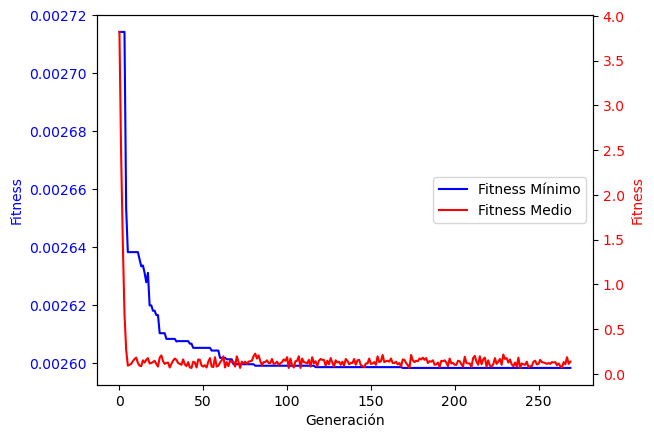

In [14]:
print("Mejor individuo: ", hof_comb[0])
print("Fitness del mejor: ", hof_comb[0].fitness.values[0])
representaAlgoritmoGenetico(logbook)

Fitness LPT:  0.004467990343310853
Fitness LPTEDD:  0.004877853334892653
Fitness Combinado:  0.002598424209668574
Fitness Genético:  0.0026698868012951273


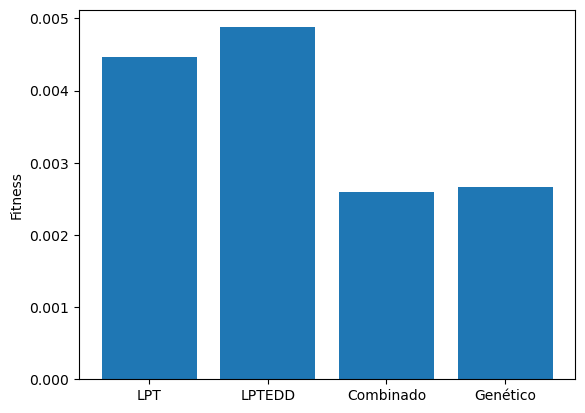

In [15]:
# Se representan los fitness de los mejores individuos
mejor_LPT = toolbox.indModelo()
mejor_LPTEDD = toolbox.indModeloDos()
mejor_comb = hof_comb[0]
mejor_gene = hof[0]

# Se evalúan
mejor_LPT.fitness.values = toolbox.evaluate(mejor_LPT)
mejor_LPTEDD.fitness.values = toolbox.evaluate(mejor_LPTEDD)
mejor_comb.fitness.values = toolbox.evaluate(mejor_comb)
mejor_gene.fitness.values = toolbox.evaluate(mejor_gene)

# Se representan
print("Fitness LPT: ", mejor_LPT.fitness.values[0]) 
print("Fitness LPTEDD: ", mejor_LPTEDD.fitness.values[0])
print("Fitness Combinado: ", mejor_comb.fitness.values[0])
print("Fitness Genético: ", mejor_gene.fitness.values[0])

# Se representan los resultados
def representaResultados(mejor_LPT, mejor_LPTEDD, mejor_comb, mejor_gene):
    # Se representan los resultados
    fig, ax = plt.subplots()
    ax.bar([1,2,3,4],[mejor_LPT.fitness.values[0], mejor_LPTEDD.fitness.values[0], mejor_comb.fitness.values[0], mejor_gene.fitness.values[0]])
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(["LPT", "LPTEDD", "Combinado", "Genético"])
    ax.set_ylabel("Fitness")
    plt.show()

representaResultados(mejor_LPT, mejor_LPTEDD, mejor_comb, mejor_gene)